In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Networks')
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from numpy.linalg import norm
from Networks.BMF import BMF
from utils import assign_labels, cluster_acc, donor_info
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from operator import itemgetter
from tqdm import tqdm
import json
import pickle

import torch
from torch import nn
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [5]:
def Plot_2D(Labels1,title1,Labels2,title2,method1,method2=np.array([])):
    print('Preparing Visualizations')
    plt.figure(figsize=(14,7))
    if method2.size==0:
        method2=method1
    for i in range(0, method1.shape[0]):
        plt.subplot(1,2,1)
        plt.title(title1) 
        if Labels1[i] == 0:
            c1 = plt.scatter(method1[i,0],method1[i,1],c='r',
        marker='+')
        elif Labels1[i]==1:
            c2 = plt.scatter(method1[i,0],method1[i,1],c='b',
        marker='*')
        elif Labels1[i]==-1:
            c3 = plt.scatter(method1[i,0],method1[i,1],c='k',
        marker='*')

        plt.subplot(1,2,2)
        plt.title(title2) 
        if Labels2[i] == 0:
            c4 = plt.scatter(method2[i,0],method2[i,1],c='r',
        marker='+')
        elif Labels2[i]==1:
            c5 = plt.scatter(method2[i,0],method2[i,1],c='b',
        marker='*')
        elif Labels2[i]==2:
            c6 = plt.scatter(method2[i,0],method2[i,1],c='g',
        marker='*')

    plt.legend([c4, c5, c6], ['Patient 1', 'Patient 2','Doublet'])
    plt.show()
    

def reverse_acc(ground_truth,predicted):
    acc= accuracy_score(ground_truth,predicted)
    if acc<0.5:
        #y_pred_bar = np.zeros_like(predicted)
        y_pred_bar = predicted.copy()
        y_pred_bar[np.where(predicted==0)]=1
        y_pred_bar[np.where(predicted==1)]=0
        acc= accuracy_score(ground_truth,y_pred_bar)
        return acc, y_pred_bar
    return acc, predicted

def plot_important_variants(names,counts,title):
    trace = go.Bar(y=names,
                   x=counts,
                   orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

    layout = go.Layout(
        title= title, height=600, width=800,
        xaxis=dict(
            title='Number of cells',
            titlefont=dict(size=16, color='rgb(107, 107, 107)'),
            domain=[0.25, 1]
        ),
        barmode='group',
        bargap=0.1,
        bargroupgap=0.1
    )

    fig = go.Figure(data=[trace], layout=layout)
    iplot(fig)

### Loading the dataset

In [19]:
path = '/home/john/Desktop/Dissertation/Dataset1/labels_PCA'
with open(path, 'rb') as f:
    labels_dict = pickle.load(f)
labels_ID = list(labels_dict.keys())
labels = list(labels_dict.values()) 
ground = np.asarray(labels)
unk = np.where(ground==2)[0]
patients = np.delete(ground,unk,axis=0)
path_to_save = '/home/john/Desktop/Dissertation/Dataset1/Dataset_1.npy'
df_train = np.load(path_to_save)
V = np.array(df_train, dtype='int8').T
score = silhouette_score(V.T, ground, metric='euclidean')
print('2HL-BMF: Silhouette score for', 2,'clusters:' ,score)

2HL-BMF: Silhouette score for 2 clusters: 0.008396666860956747


### Distribution of variants and Labels

Dataset sparseness is: 0.06460875116429557


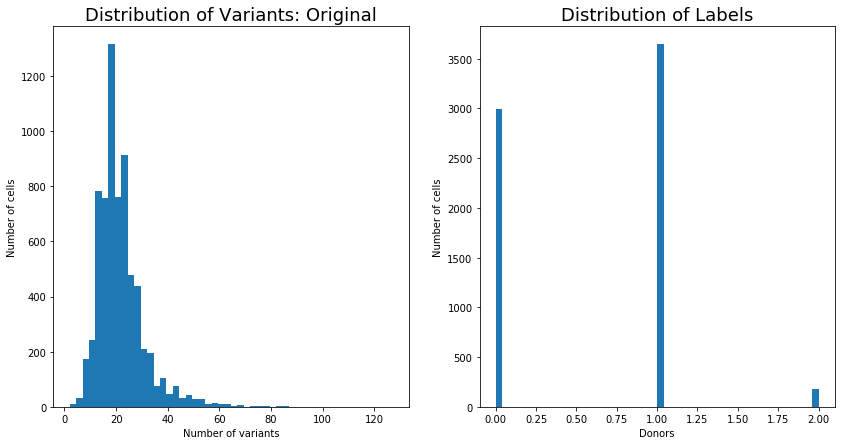

In [14]:
print("Dataset sparseness is:",np.sum(V)*100 / V.size)
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Variants: Original",fontsize=18)
plt.hist(V.sum(axis=0),bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Labels",fontsize=18)
plt.hist(ground,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

### Dimensionality reduction for visualization

In [20]:
pca = PCA(n_components=2).fit(V.T)
pca_2d = pca.transform(V.T)
path = '/home/john/Desktop/Dissertation/Dataset1/UMAP.npy'
UMAP= np.load(path)
models_labels = {} 

In [11]:
"""
clusterable_embedding = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    n_components=2,
).fit_transform(V.T)
"""

# Using standard NMF decomposition

In [21]:
path_W = '/home/john/Desktop/Dissertation/Dataset1/Decompositions/Base_basis.npy'
path_H = '/home/john/Desktop/Dissertation/Dataset1/Decompositions/Base_coeff.npy'
W = np.load(path_W)
H = np.load(path_H)

t = norm(V-np.dot(W,H),'fro')
print('The distance using Penalty Algorithm is:',t)
labels_base = assign_labels(labels_ID,H)
pred_base = np.array(list(labels_base.values()))
_, pred_base = reverse_acc(ground,pred_base)
models_labels['PCA'] = ground

The distance using Penalty Algorithm is: 402.05549360943047


In [22]:
kmeans = GaussianMixture(n_components=2,covariance_type='diag')
pred_GMM = kmeans.fit_predict(H.T)
_, pred_GMM = reverse_acc(ground,pred_GMM)   
models_labels['NMF-BMF-GMM'] = pred_GMM

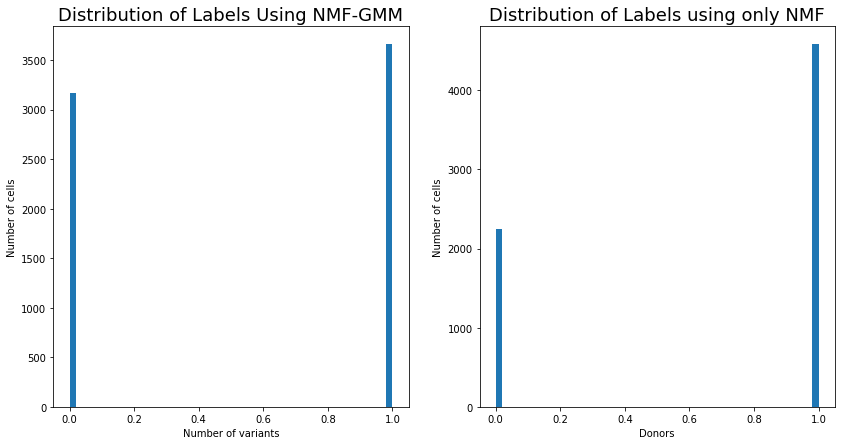

In [13]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Labels Using NMF-GMM",fontsize=18)
plt.hist(y_pred,bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Labels using only NMF",fontsize=18)
plt.hist(pred_base,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

In [14]:
acc= accuracy_score(patients,np.delete(y_pred,unk,axis=0))
print("Labels using GMM acquired match: ",acc)  
print("Labels acquired match: ",accuracy_score(patients,np.delete(pred_base,unk,axis=0)))
acc = accuracy_score(pred_2HL,pred_base)
print('Accuracy of base BMF and 2HL is:', acc,'\n')

nmi = nmi_score(ground,pred_base)
ari = ari_score(ground,pred_base)
print('Ground-Base Normalized mutual info score is:',nmi)
print("Ground-Base Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_base,pred_2HL)
ari = ari_score(pred_base,pred_2HL)
print('2HLBMF-Base Normalized mutual info score is:',nmi)
print("2HLBMF-Base Adjusted rand score is:",ari,"\n")

score = silhouette_score(V.T, pred_base, metric='euclidean')
print('Standard BMF: Silhouette score for', 2,'clusters:' ,score)
score = silhouette_score(V.T, y_pred, metric='euclidean')
print('Standard BMF: Silhouette score for', 2,'clusters:' ,score)

Labels using GMM acquired match:  0.8790844752296341
Labels acquired match:  0.8376750489384129
Accuracy of base BMF and 2HL is: 0.839953099809468 

Ground-Base Normalized mutual info score is: 0.3651016469625033
Ground-Base Adjusted rand score is: 0.42705705020851326 

2HLBMF-Base Normalized mutual info score is: 0.32999560962532265
2HLBMF-Base Adjusted rand score is: 0.4561577918348794 



/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Standard BMF: Silhouette score for 2 clusters: 0.01717029382084958
Standard BMF: Silhouette score for 2 clusters: 0.015493656127958326


###### Plot the data using UMAP

Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


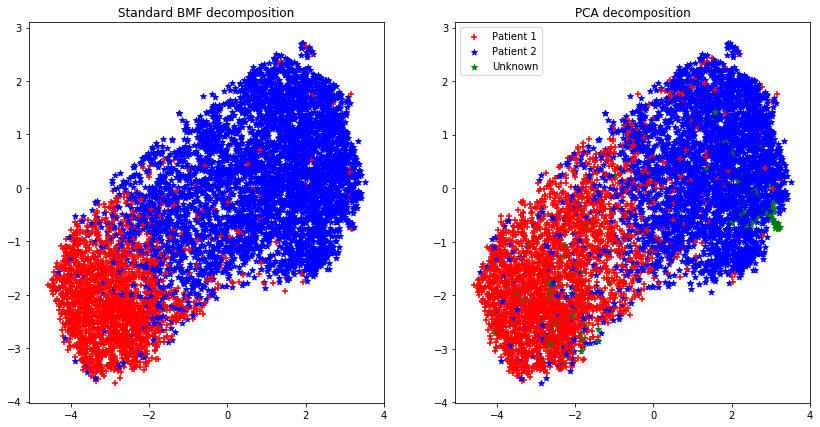

In [38]:
title1 = 'Standard BMF decomposition'
title2 = 'PCA decomposition'
Plot_2D(pred_base,title1,ground,title2,UMAP)

###### Latent space representation in 2D

/home/john/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


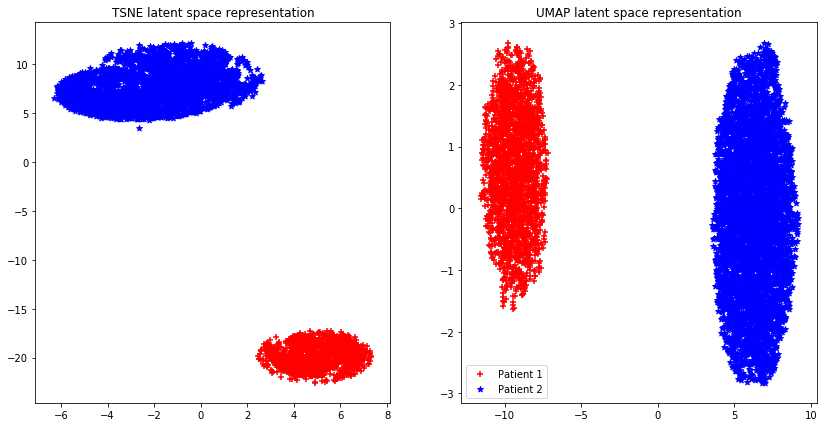

In [48]:
X_embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(H.T)

X_embedded = TSNE(n_components=2,
                  perplexity=50,
                  metric='correlation').fit_transform(H.T)

title1 = 'TSNE latent space representation'
title2 = 'UMAP latent space representation'
Plot_2D(pred_base,title1,pred_base,title2,X_embedded,X_embedding)

# Using 3HL VAE

In [23]:
path = '/home/john/Desktop/Dissertation/Dataset1/Decompositions/3HL_BMF_basis.npy'
W = np.load(path)
path = '/home/john/Desktop/Dissertation/Dataset1/Decompositions/3HL_BMF_coeff.npy'
H = np.load(path)

t = norm(V-np.dot(W,H),'fro')
print('The distance using Penalty Algorithm is:',t)

labels_3HL_BMF = assign_labels(labels_ID, H)
pred_3HL = np.array(list(labels_3HL_BMF.values()))
_, pred_3HL = reverse_acc(ground,pred_3HL) 
kmeans = GaussianMixture(n_components=2,covariance_type='diag')
y_pred = kmeans.fit_predict(H.T)
_, y_pred = reverse_acc(ground,y_pred) 
models_labels['PNMF-BMF-GMM'] = y_pred 

The distance using Penalty Algorithm is: 400.9588


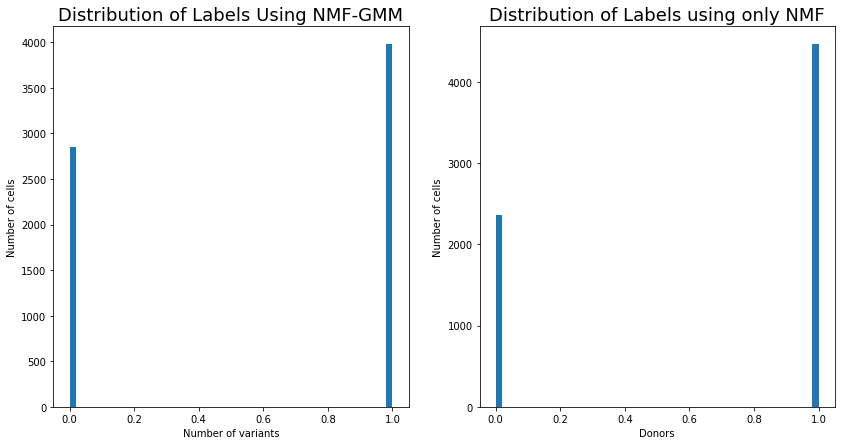

In [8]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Labels Using NMF-GMM",fontsize=18)
plt.hist(y_pred,bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Labels using only NMF",fontsize=18)
plt.hist(pred_3HL,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

In [30]:
acc= accuracy_score(patients,np.delete(y_pred,unk,axis=0))
print('Labels using GMM acquired match:',acc)  
acc = accuracy_score(patients,np.delete(pred_3HL,unk,axis=0))
print('Labels acquired match:', acc)
acc = accuracy_score(pred_3HL,pred_base)
print('Accuracy of base BMF and 3HL is:', acc,'\n')

nmi = nmi_score(ground,pred_3HL)
ari = ari_score(ground,pred_3HL)
print('Ground-Base Normalized mutual info score is:',nmi)
print("Ground-Base Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_base,pred_3HL)
ari = ari_score(pred_base,pred_3HL)
print('3HLBMF-Base Normalized mutual info score is:',nmi)
print("3HLBMF-Base Adjusted rand score is:",ari,"\n")


score = silhouette_score(V.T, pred_3HL, metric='euclidean')
print('3HL-BMF: Silhouette score for', 2,'clusters:' ,score)

Labels using GMM acquired match: 0.5154344225267279
Labels acquired match: 0.8370727300105406
Accuracy of base BMF and 3HL is: 0.8242708486003224 

Ground-Base Normalized mutual info score is: 0.3391290864130043
Ground-Base Adjusted rand score is: 0.4234924478785814 

3HLBMF-Base Normalized mutual info score is: 0.3033333218261444
3HLBMF-Base Adjusted rand score is: 0.4160209988403636 



/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning:

The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.



3HL-BMF: Silhouette score for 2 clusters: 0.005527890227509829


###### Plot the data using UMAP

Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


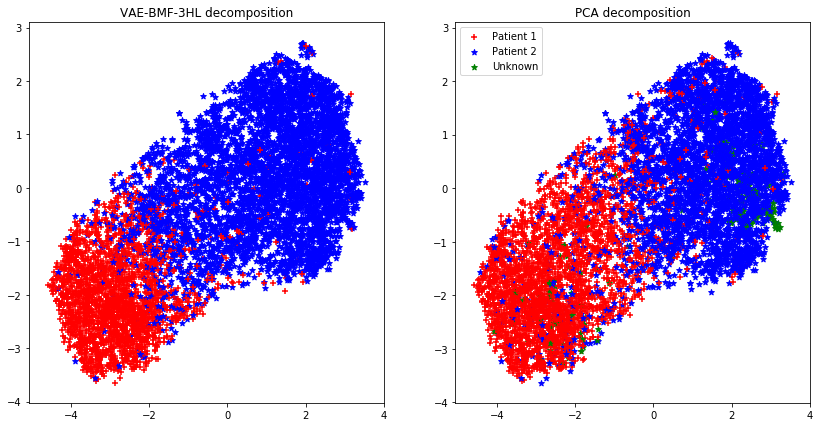

In [47]:
title1 = 'VAE-BMF-3HL decomposition'
title2 = 'PCA decomposition'
Plot_2D(pred_3HL,title1,ground,title2,UMAP)

###### Latent space representation in 2D

/home/john/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py:723: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
/home/john/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


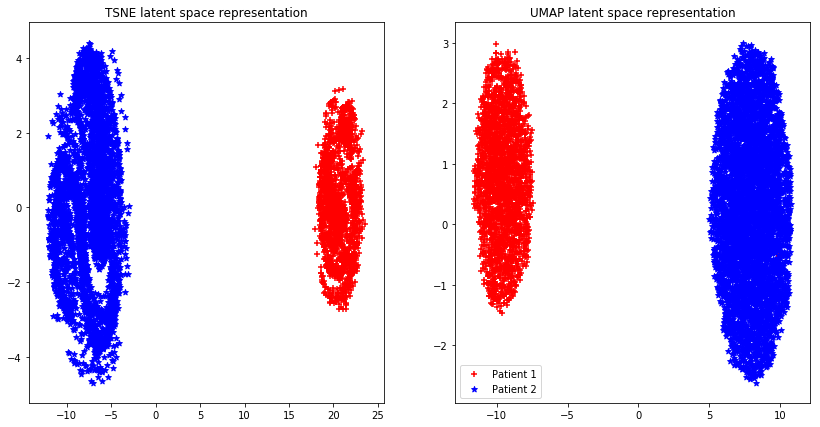

In [65]:
X_embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(H.T)

X_embedded = TSNE(n_components=2,
                  perplexity=50,
                  metric='correlation').fit_transform(H.T)

title1 = 'TSNE latent space representation'
title2 = 'UMAP latent space representation'
Plot_2D(pred_3HL,title1,pred_3HL,title2,X_embedded,X_embedding)

# UMAP - HDBSCAN

In [8]:
import hdbscan
hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(UMAP)
_, hdbscan_labels = reverse_acc(ground,hdbscan_labels) 
hdbscan_labels[np.where(hdbscan_labels==-1)]=2 
noise = np.where(hdbscan_labels==2)[0]
clustered = np.delete(hdbscan_labels,noise,axis=0)
acc= accuracy_score(patients,np.delete(hdbscan_labels,unk,axis=0))
print('Labels acquired match:', acc)

Labels acquired match: 0.806655624152989


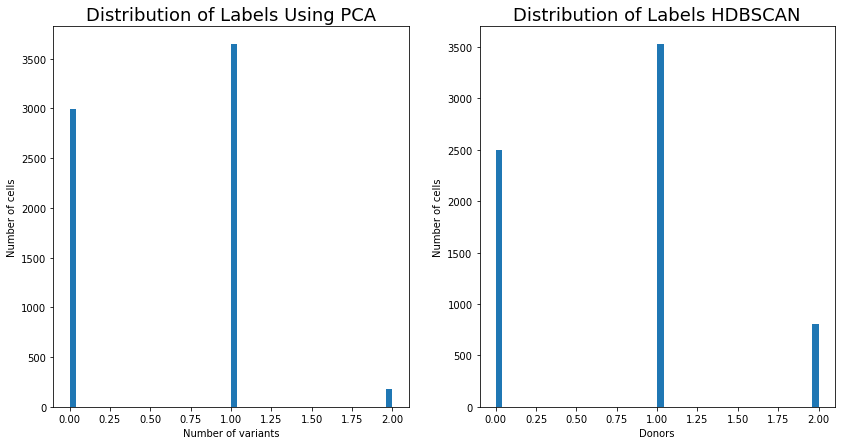

In [34]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Labels Using PCA",fontsize=18)
plt.hist(ground,bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Labels HDBSCAN",fontsize=18)
plt.hist(hdbscan_labels,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

In [10]:
acc= accuracy_score(clustered,np.delete(pred_2HL,noise,axis=0))
print('Accuracy of 2HL and HDBSCAN Clustering is:', acc)
acc= accuracy_score(clustered,np.delete(pred_3HL,noise,axis=0))
print('Accuracy of base 3HL and HDBSCAN Clustering is:', acc)
acc= accuracy_score(clustered,np.delete(pred_base,noise,axis=0))
print('Accuracy is base BMF and HDBSCAN Clustering is:', acc,"\n")

nmi = nmi_score(clustered,np.delete(pred_base,noise,axis=0))
ari = ari_score(clustered,np.delete(pred_base,noise,axis=0))
print('HDBSCAN-Base Normalized mutual info score is:',nmi)
print("HDBSCAN-Base Adjusted rand score is:",ari,"\n")

nmi = nmi_score(clustered,np.delete(pred_3HL,noise,axis=0))
ari = ari_score(clustered,np.delete(pred_3HL,noise,axis=0))
print('3HLBMF-HDBSCAN Normalized mutual info score is:',nmi)
print("3HLBMF-HDBSCAN Adjusted rand score is:",ari,"\n")

nmi = nmi_score(clustered,np.delete(pred_2HL,noise,axis=0))
ari = ari_score(clustered,np.delete(pred_2HL,noise,axis=0))
print('2HLBMF-HDBSCAN Normalized mutual info score is:',nmi)
print("2HLBMF-HDBSCAN Adjusted rand score is:",ari,"\n")

score = silhouette_score(V.T, hdbscan_labels, metric='euclidean')
print('UMAP-HDBSCAN: Silhouette score for', 2,'clusters:' ,score)

Accuracy of 2HL and HDBSCAN Clustering is: 0.862670209232813
Accuracy of base 3HL and HDBSCAN Clustering is: 0.9239455330454999
Accuracy is base BMF and HDBSCAN Clustering is: 0.9114911989372302 

HDBSCAN-Base Normalized mutual info score is: 0.5961783546328545
HDBSCAN-Base Adjusted rand score is: 0.6763378997926046 

3HLBMF-HDBSCAN Normalized mutual info score is: 0.6295309800715535
3HLBMF-HDBSCAN Adjusted rand score is: 0.718231263030499 

2HLBMF-HDBSCAN Normalized mutual info score is: 0.4213013663691452
2HLBMF-HDBSCAN Adjusted rand score is: 0.5248987365178966 



/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


UMAP-HDBSCAN: Silhouette score for 2 clusters: -0.015184979503742731


Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


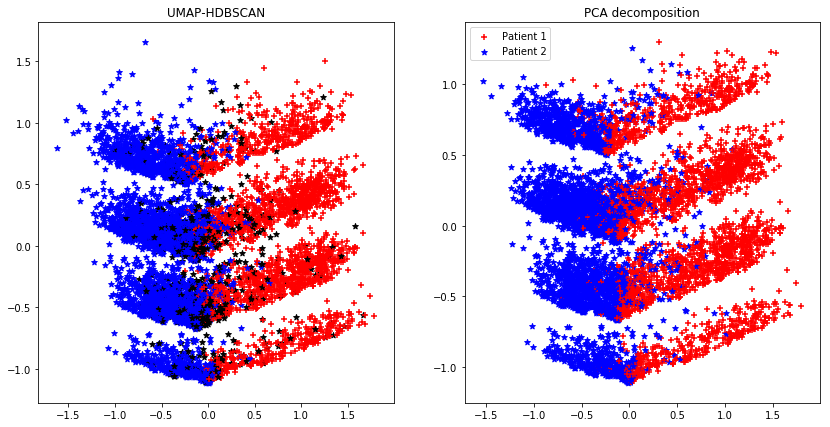

In [93]:
title1 = 'UMAP-HDBSCAN'
title2 = 'PCA decomposition'
Plot_2D(hdbscan_labels,title1,ground,title2,pca_2d)

Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


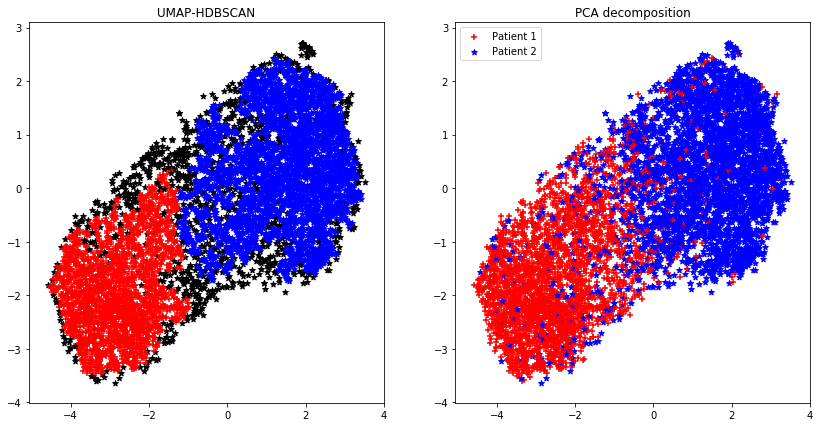

In [94]:
title1 = 'UMAP-HDBSCAN'
title2 = 'PCA decomposition'
Plot_2D(hdbscan_labels,title1,ground,title2,UMAP)

# IDEC - K MEANS

In [6]:
from IDEC import IDEC

device = torch.device("cpu")
input_dims = 33337
encoder_dims = [700,500,1000]
latent_space = 2
decoder_dims = encoder_dims[::-1]
pretrain = '/home/john/Desktop/Dissertation/Dataset1/Pretrained Weights/IDEC.pt'
model = IDEC(input_dims,
            encoder_dims,
            latent_space,
            decoder_dims,
            2).to(device)
model.load_model(pretrain)
#fn = '/home/john/Desktop/Dissertation/Dataset1/Pretrained Weights/IDEC_3_cor'
#model.load_state_dict(torch.load(fn))

model.eval()
device = torch.device('cpu')
path = '/home/john/Desktop/Dissertation/Dataset1/Dataset_1.npy'
data = np.load(path)
row = torch.from_numpy(np.array(data, dtype='float32'))
row = row.to(device)

_ , latent = model.ae(row)
latent_space = latent.data.cpu().numpy()

kmeans = KMeans(n_clusters=2)
pred_IDEC = kmeans.fit_predict(latent_space)
_, pred_IDEC = reverse_acc(ground,pred_IDEC)
acc= cluster_acc(patients,np.delete(pred_IDEC,unk,axis=0))[0]
print('Labels acquired match Ground-IDEC:', acc)
models_labels['IDEC-KMEANS'] = pred_IDEC

/home/john/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



NameError: name 'ground' is not defined

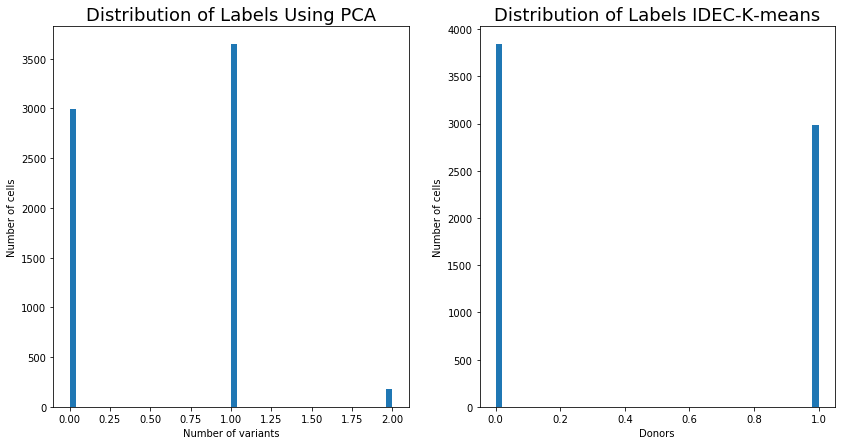

In [37]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Labels Using PCA",fontsize=18)
plt.hist(ground,bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Labels IDEC-K-means",fontsize=18)
plt.hist(pred_IDEC,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

In [15]:
acc= accuracy_score(pred_IDEC,pred_2HL)
print('Accuracy of 2HL and IDEC Clustering is:', acc)
acc= accuracy_score(pred_IDEC,pred_base)
print('Accuracy of standard NMF and IDEC Clustering is:', acc)
acc= accuracy_score(pred_IDEC,pred_3HL)
print('Accuracy of base 3HL and IDEC Clustering is:', acc)
acc= accuracy_score(clustered,np.delete(pred_IDEC,noise,axis=0))
print('Accuracy is base IDEC and HDBSCAN Clustering is:', acc,"\n")

nmi = nmi_score(pred_IDEC,ground)
ari = ari_score(pred_IDEC,ground)
print('IDEC-Ground Normalized mutual info score is:',nmi)
print("IDEC-Ground Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_IDEC,pred_base)
ari = ari_score(pred_IDEC,pred_base)
print('IDEC-Base Normalized mutual info score is:',nmi)
print("IDEC-Base Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_IDEC,pred_3HL)
ari = ari_score(pred_IDEC,pred_3HL)
print('3HLBMF-IDEC Normalized mutual info score is:',nmi)
print("3HLBMF-IDEC Adjusted rand score is:",ari,"\n")

nmi = nmi_score(clustered,np.delete(pred_IDEC,noise,axis=0))
ari = ari_score(clustered,np.delete(pred_IDEC,noise,axis=0))
print('IDEC-HDBSCAN Normalized mutual info score is:',nmi)
print("IDEC-HDBSCAN Adjusted rand score is:",ari,"\n")

score = silhouette_score(V.T, pred_IDEC, metric='euclidean')
print('IDEC: Silhouette score for', 2,'clusters:' ,score)

Accuracy of 2HL and IDEC Clustering is: 0.8093214128682398
Accuracy of standard NMF and IDEC Clustering is: 0.7996482485710098
Accuracy of base 3HL and IDEC Clustering is: 0.8143045581122673
Accuracy is base IDEC and HDBSCAN Clustering is: 0.8844237794752574 

IDEC-Ground Normalized mutual info score is: 0.5961061676881312
IDEC-Ground Adjusted rand score is: 0.701499855234015 

IDEC-Base Normalized mutual info score is: 0.3468468820845175
IDEC-Base Adjusted rand score is: 0.35905558456164827 

3HLBMF-IDEC Normalized mutual info score is: 0.3692057642231861
3HLBMF-IDEC Adjusted rand score is: 0.3950555980514786 

IDEC-HDBSCAN Normalized mutual info score is: 0.5109160349395908
IDEC-HDBSCAN Adjusted rand score is: 0.5910528550146218 



/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


IDEC: Silhouette score for 2 clusters: 0.011654946879045162


###### Latent space representation in 2D

/home/john/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


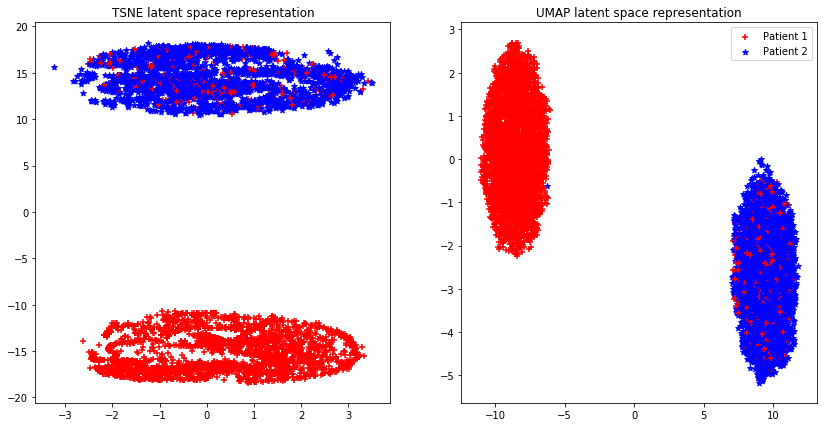

In [12]:
X_embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(latent_space)

X_embedded = TSNE(n_components=2,
                  perplexity=50,
                  metric='correlation').fit_transform(latent_space)

title1 = 'TSNE latent space representation'
title2 = 'UMAP latent space representation'
Plot_2D(pred_IDEC,title1,pred_IDEC,title2,X_embedded,X_embedding)

Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


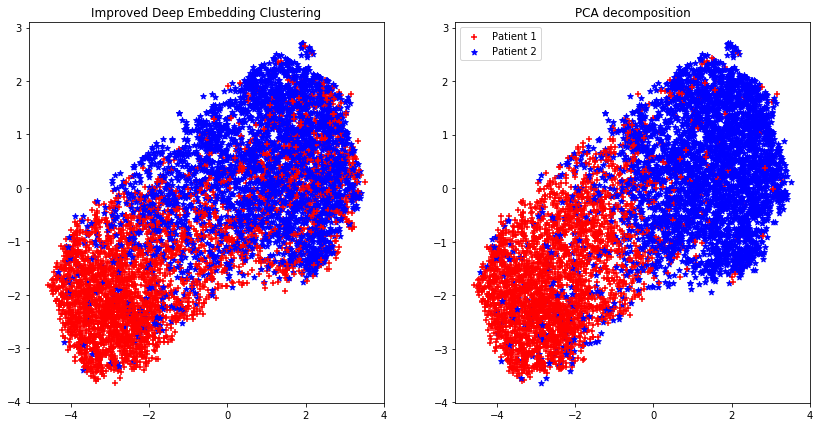

In [15]:
title1 = 'Improved Deep Embedding Clustering'
title2 = 'PCA decomposition'
Plot_2D(pred_IDEC,title1,ground,title2,UMAP)

# IDEC - GMM

In [25]:
kmeans = GaussianMixture(n_components=2, covariance_type='diag')
pred_ICA = kmeans.fit_predict(latent_space)
_, pred_ICA = reverse_acc(ground,pred_GMM)   
acc= accuracy_score(patients,np.delete(pred_GMM,unk,axis=0))
print('Labels acquired match Ground-IDEC:', acc)
models_labels['IDEC-GMM'] = pred_ICA

Labels acquired match Ground-IDEC: 0.8790844752296341


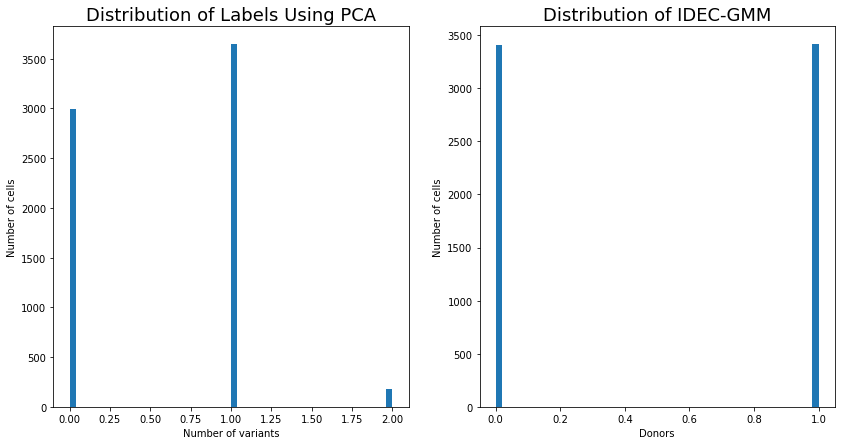

In [43]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Labels Using PCA",fontsize=18)
plt.hist(ground,bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of IDEC-GMM",fontsize=18)
plt.hist(pred_GMM,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

In [19]:
acc= cluster_acc(pred_ICA,pred_2HL)[0]
print('Accuracy of 2HL and IDEC Clustering is:', acc)
acc= cluster_acc(pred_ICA,pred_base)[0]
print('Accuracy of standard NMF and IDEC Clustering is:', acc)
acc= cluster_acc(pred_ICA,pred_3HL)[0]
print('Accuracy of base 3HL and IDEC Clustering is:', acc)
acc= cluster_acc(pred_IDEC,pred_ICA)[0]
print('Accuracy of base IDEC_ICA and IDEC Clustering is:', acc)
acc= cluster_acc(clustered,np.delete(pred_ICA,noise,axis=0))[0]
print('Accuracy is base IDEC and HDBSCAN Clustering is:', acc,"\n")

nmi = nmi_score(pred_ICA,ground)
ari = ari_score(pred_ICA,ground)
print('IDEC-Ground Normalized mutual info score is:',nmi)
print("IDEC-Ground Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_ICA,pred_base)
ari = ari_score(pred_ICA,pred_base)
print('IDEC-Base Normalized mutual info score is:',nmi)
print("IDEC-Base Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_ICA,pred_3HL)
ari = ari_score(pred_ICA,pred_3HL)
print('3HLBMF-IDEC Normalized mutual info score is:',nmi)
print("3HLBMF-IDEC Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_IDEC,pred_ICA)
ari = ari_score(pred_IDEC,pred_ICA)
print('IDEC_ICA-IDEC Normalized mutual info score is:',nmi)
print("IDEC_ICA-IDEC Adjusted rand score is:",ari,"\n")

nmi = nmi_score(clustered,np.delete(pred_ICA,noise,axis=0))
ari = ari_score(clustered,np.delete(pred_ICA,noise,axis=0))
print('IDEC_ICA-HDBSCAN Normalized mutual info score is:',nmi)
print("IDEC_ICA-HDBSCAN Adjusted rand score is:",ari,"\n")

score = silhouette_score(V.T, pred_ICA, metric='euclidean')
print('IDEC: Silhouette score for', 2,'clusters:' ,score)

Accuracy of 2HL and IDEC Clustering is: 0.8093214128682398
Accuracy of standard NMF and IDEC Clustering is: 0.7996482485710098
Accuracy of base 3HL and IDEC Clustering is: 0.8143045581122673
Accuracy of base IDEC_ICA and IDEC Clustering is: 1.0
Accuracy is base IDEC and HDBSCAN Clustering is: 0.8844237794752574 

IDEC-Ground Normalized mutual info score is: 0.5961061676881312
IDEC-Ground Adjusted rand score is: 0.701499855234015 

IDEC-Base Normalized mutual info score is: 0.3468468820845175
IDEC-Base Adjusted rand score is: 0.35905558456164827 

3HLBMF-IDEC Normalized mutual info score is: 0.3692057642231861
3HLBMF-IDEC Adjusted rand score is: 0.3950555980514786 

IDEC_ICA-IDEC Normalized mutual info score is: 1.0
IDEC_ICA-IDEC Adjusted rand score is: 1.0 

IDEC_ICA-HDBSCAN Normalized mutual info score is: 0.5109160349395908
IDEC_ICA-HDBSCAN Adjusted rand score is: 0.5910528550146218 



/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


IDEC: Silhouette score for 2 clusters: 0.011654946879045162


###### Latent space representation in 2D

/home/john/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


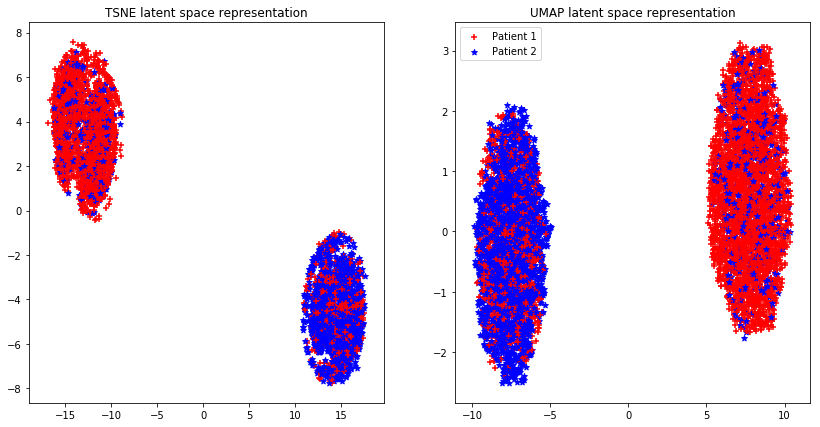

In [122]:
X_embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_transformed)

X_embedded = TSNE(n_components=2,
                  perplexity=50,
                  metric='correlation').fit_transform(X_transformed)

title1 = 'TSNE latent space representation'
title2 = 'UMAP latent space representation'
Plot_2D(pred_ICA,title1,pred_ICA,title2,X_embedded,X_embedding)

Preparing Visualizations


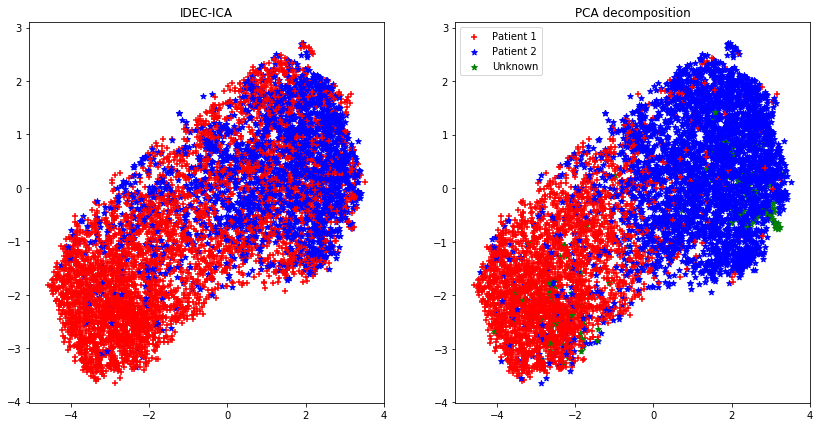

In [164]:
title1 = 'IDEC-ICA'
title2 = 'PCA decomposition'
Plot_2D(pred_ICA,title1,ground,title2,UMAP)

# Variational Deep Embedding

In [26]:
from Networks.VADE import VaDE
vade = VaDE(input_dim=33337, z_dim=2,n_centroids=2, binary=True,
    encodeLayer=[700,500,1000], decodeLayer=[1000,500,700])
vade.load_model("/home/john/Desktop/Dissertation/Dataset1/Pretrained Weights/VaDE_3HL.pt")
z, _, _, _ =vade.forward(row)
pc = vade.compute_gamma(z)
pred_vade = np.argmax(pc.detach().numpy(), axis=1)
_, pred_vade = reverse_acc(ground,pred_vade)
print("Vade - IDEC accuracy:",cluster_acc(pred_vade,ground)[0])
models_labels['VADE'] = pred_vade

Vade - IDEC accuracy: 0.9010699105965118


In [11]:
vade = VaDE(input_dim=33337, z_dim=3,n_centroids=3, binary=True,
    encodeLayer=[700,500,1000], decodeLayer=[1000,500,700])
vade.load_model("/home/john/Desktop/Dissertation/Dataset1/Pretrained Weights/VaDE_1_doublet.pt")
z_doublet, _, _, _ =vade.forward(row)
pc = vade.compute_gamma(z_doublet)
pred_vade_doublet = np.argmax(pc.detach().numpy(), axis=1)
pred_vade_vis = pred_vade_doublet
_, pred_vade_doublet = reverse_acc(ground,pred_vade_doublet)
print("Vade - PCA accuracy:",cluster_acc(pred_vade_doublet,ground)[0])
print("Vade - Vade doublets:",cluster_acc(pred_vade,pred_vade_doublet)[0])
models_labels['VADE_doublet'] = pred_vade_doublet

Vade - PCA accuracy: 0.8889051736772681
Vade - Vade doublets: 0.8672138355562069


Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



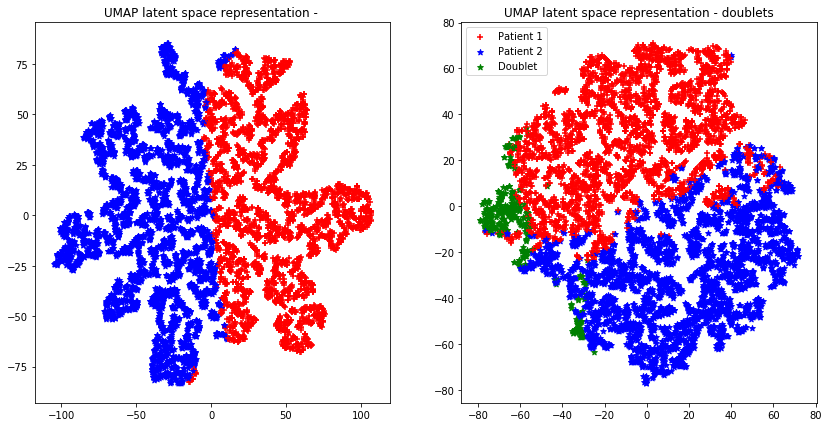

In [44]:
z = z.detach().numpy()
z_doublet = z_doublet.detach().numpy()
X_embedding = TSNE(n_components=2,
                  perplexity=30,
                  metric='manhattan').fit_transform(z)

X_embedded = TSNE(n_components=2,
                  perplexity=50,
                  metric='manhattan').fit_transform(z_doublet)

title1 = 'UMAP latent space representation - '
title2 = 'UMAP latent space representation - doublets'
Plot_2D(pred_vade,title1,pred_vade_vis,title2,X_embedding,X_embedded)

Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



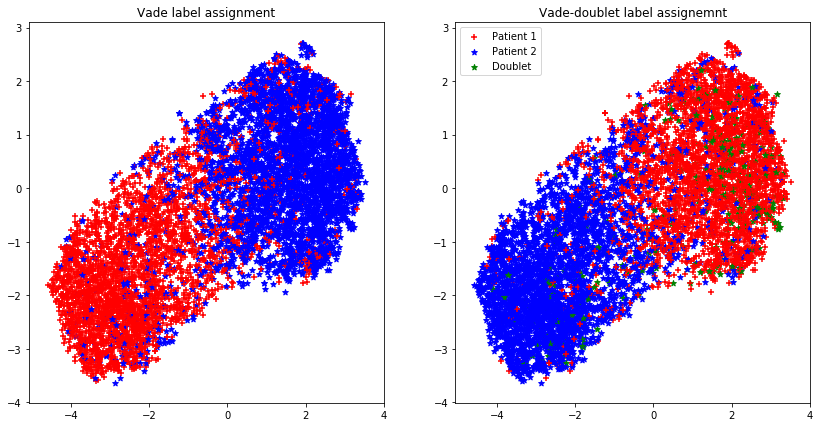

In [45]:
title1 = 'Vade label assignment'
title2 = 'Vade-doublet label assignemnt'
Plot_2D(pred_vadepred_vade_vis_vade_vis,title2,UMAP)

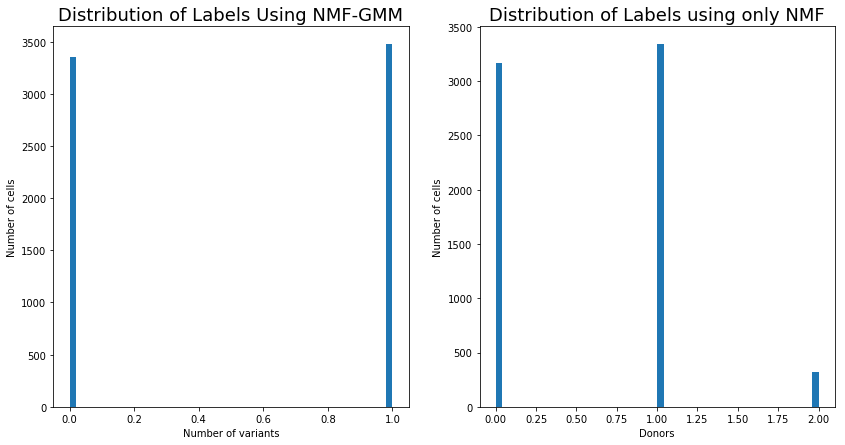

In [66]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Labels Using NMF-GMM",fontsize=18)
plt.hist(pred_vade,bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Labels using only NMF",fontsize=18)
plt.hist(pred_vade_doublet,bins=50)
plt.xlabel('Donors')
plt.ylabel('Number of cells')
plt.show()

In [71]:
acc= cluster_acc(pred_vade,pred_GMM)[0]
print('Accuracy of standard NMF and VaDE Clustering is:', acc)
acc= cluster_acc(pred_vade,y_pred)[0]
print('Accuracy of base 3HL and VaDE Clustering is:', acc)
acc= cluster_acc(pred_vade,pred_IDEC)[0]
print('Accuracy of base IDEC and VaDE Clustering is:', acc)
acc= cluster_acc(pred_vade,pred_ICA)[0]
print('Accuracy of base IDEC-GMM and VaDE Clustering is:', acc)
acc= cluster_acc(clustered,np.delete(pred_vade,noise,axis=0))[0]
print('Accuracy is base VaDE and HDBSCAN Clustering is:', acc,"\n")

nmi = nmi_score(pred_vade,ground)
ari = ari_score(pred_vade,ground)
print('VaDE-Ground Normalized mutual info score is:',nmi)
print("VaDE-Ground Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_vade,pred_base)
ari = ari_score(pred_vade,pred_base)
print('VaDE-Base Normalized mutual info score is:',nmi)
print("VaDE-Base Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_vade,pred_3HL)
ari = ari_score(pred_vade,pred_3HL)
print('3HLBMF-VaDE Normalized mutual info score is:',nmi)
print("3HLBMF-VaDE Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_vade,pred_IDEC)
ari = ari_score(pred_vade,pred_IDEC)
print('VaDE_IDEC Normalized mutual info score is:',nmi)
print("VaDE_IDEC Adjusted rand score is:",ari,"\n")

nmi = nmi_score(pred_vade,pred_ICA)
ari = ari_score(pred_vade,pred_ICA)
print('VaDE_IDEC GMM Normalized mutual info score is:',nmi)
print("VaDE_IDEC GMM Adjusted rand score is:",ari,"\n")

nmi = nmi_score(clustered,np.delete(pred_vade,noise,axis=0))
ari = ari_score(clustered,np.delete(pred_vade,noise,axis=0))
print('VaDE-HDBSCAN Normalized mutual info score is:',nmi)
print("VaDE-HDBSCAN Adjusted rand score is:",ari,"\n")

score = silhouette_score(V.T, pred_vade, metric='euclidean')
print('VaDE: Silhouette score for', 2,'clusters:' ,score)

Accuracy of standard NMF and VaDE Clustering is: 0.8400996629048806
Accuracy of base 3HL and VaDE Clustering is: 0.8250036640773853
Accuracy of base IDEC and VaDE Clustering is: 0.8767404367580244
Accuracy of base IDEC-GMM and VaDE Clustering is: 0.8400996629048806
Accuracy is base VaDE and HDBSCAN Clustering is: 0.861341746927931 

VaDE-Ground Normalized mutual info score is: 0.5640592778443768
VaDE-Ground Adjusted rand score is: 0.6987022273075872 

VaDE-Base Normalized mutual info score is: 0.3397853672822933
VaDE-Base Adjusted rand score is: 0.3609190022085003 

3HLBMF-VaDE Normalized mutual info score is: 0.35998270689113077
3HLBMF-VaDE Adjusted rand score is: 0.3966229016836972 

VaDE_IDEC Normalized mutual info score is: 0.5192359453102857
VaDE_IDEC Adjusted rand score is: 0.6404558110586231 

VaDE_IDEC GMM Normalized mutual info score is: 0.40981138860642347
VaDE_IDEC GMM Adjusted rand score is: 0.5276425658380585 

VaDE-HDBSCAN Normalized mutual info score is: 0.49602573747595

/home/john/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning:

The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.



VaDE: Silhouette score for 2 clusters: 0.006346535518133465


/home/john/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



Preparing Visualizations


/home/john/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning:


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



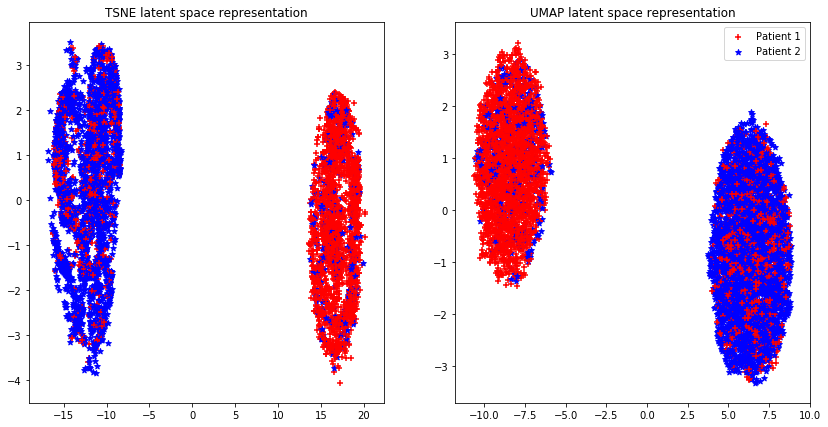

In [17]:
z = z.detach().numpy()
X_embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(z)

X_embedded = TSNE(n_components=2,
                  perplexity=50,
                  metric='correlation').fit_transform(z)

title1 = 'TSNE latent space representation'
title2 = 'UMAP latent space representation'
Plot_2D(pred_vade,title1,pred_vade,title2,X_embedded,X_embedding)

Preparing Visualizations


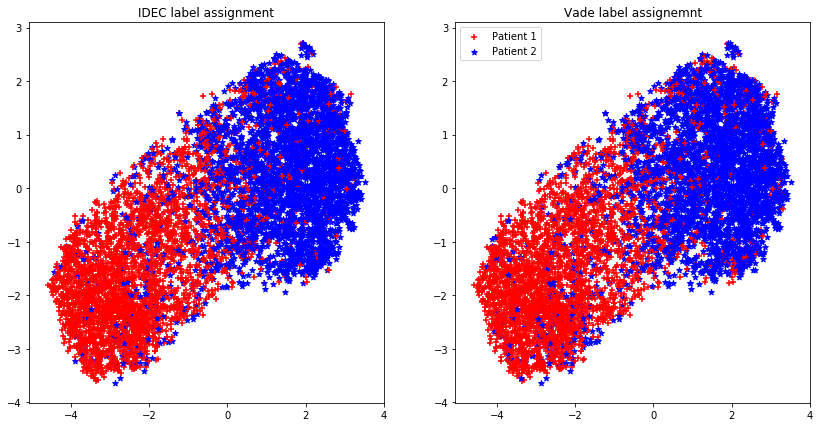

In [18]:
title1 = 'IDEC label assignment'
title2 = 'Vade label assignemnt'
Plot_2D(pred_IDEC,title1,pred_vade,title2,UMAP)

# Variants Cell Analysis

Percentage of cells assigned to the same cluster: 0.7489374175582588


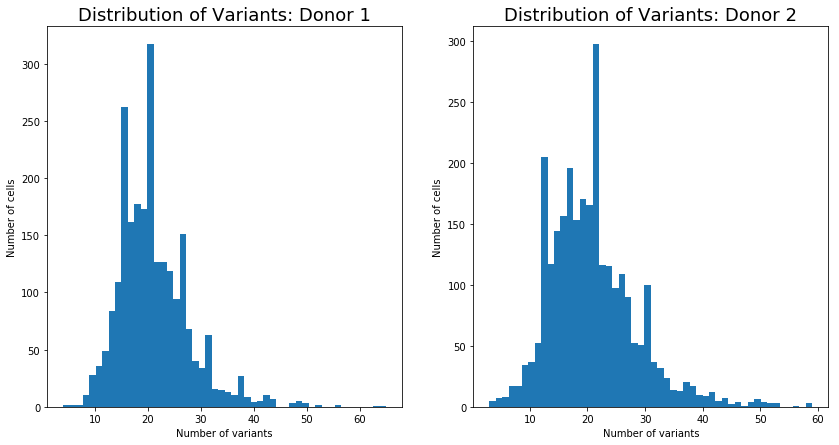

In [38]:
path = '/home/john/Desktop/Dissertation/Dataset1/variants'
with open(path, 'rb') as file:
    variants = pickle.load(file) 
dataset = V.T
path = '/home/john/Desktop/Dissertation/Dataset1'
top =20
output_dir = donor_info(dataset,models_labels,var=variants)

print("Percentage of cells assigned to the same cluster:",(len(output_dir['donor1_index'])
                                                           +len(output_dir['donor2_index'])) / V.shape[1])
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Distribution of Variants: Donor 1",fontsize=18)
plt.hist(V.T[output_dir['donor1_index']].sum(axis=1),bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')

plt.subplot(1,2,2)
plt.title("Distribution of Variants: Donor 2",fontsize=18)
plt.hist(V.T[output_dir['donor2_index']].sum(axis=1),bins=50)
plt.xlabel('Number of variants')
plt.ylabel('Number of cells')
plt.show()

In [28]:
col = list(output_dir['donor1_top20'].keys()) 
values = list(output_dir['donor1_top20'].values())
plot_important_variants(col,values,"Donor 1")
col1 = list(output_dir['donor2_top20'].keys()) 
values1 = list(output_dir['donor2_top20'].values())
plot_important_variants(col1,values1,"Donor 2")

In [39]:
col = list(output_dir['donor1_top20'].keys()) 
values = list(output_dir['donor1_top20'].values())
plot_important_variants(col,values,"Donor 1")
col1 = list(output_dir['donor2_top20'].keys()) 
values1 = list(output_dir['donor2_top20'].values())
plot_important_variants(col1,values1,"Donor 2")

In [ ]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5)
knn.fit(row)

In [22]:
IDX = knn.kneighbors(row, return_distance=False)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 33337 while Y.shape[1] == 2